In [1]:
# ! pip install imbalanced-learn
# ! pip install lime
# nltk.download('stopwords')
# ! pip install textblob
# ! pip install contractions
# ! pip install spacy
# ! python -m spacy download en_core_web_sm

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import pickle 
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import time

import nltk
from nltk.corpus import stopwords
import lime
import lime.lime_tabular

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA
from helpers import *

## Load cleaned data
combine title and body of text 

In [27]:
aita_2 = pd.read_csv('data/aita_save2.csv')
aita_2.dropna(subset=['body_clean', 'title_clean'], inplace=True)

aita = aita_2.loc[:,['body_polarity','body_subjectivity','is_asshole']]
aita['title_body_combo'] =  aita_2['title_clean'] + aita_2['body_clean']
aita.dropna(inplace=True)
aita.reset_index(drop=True)

,body_polarity,body_subjectivity,is_asshole,title_body_combo
0,-0.156818,0.656818,1,I write an explanation in til and come off a...
1,0.034848,0.449242,1,throw my parent donut awaymy parent be diabe...
2,0.000000,0.000000,0,I tell a goth girl she look like a clownI be four
3,0.000000,0.000000,1,argument I have with another redditor in rhi...
4,0.040104,0.369792,1,have a disagreement about le miserable with ...
...,...,...,...,...
97450,0.016111,0.385278,0,for tell my sister she be be a spoiled bratm...
97451,0.068461,0.474614,0,for tell my husband to f off after he relent...
97452,-0.076333,0.493467,0,for attempt to keep my student out of adult ...
97453,0.067130,0.426132,0,if I leave my brother fate up to the statea ...


## 1 - train test split

In [42]:
X = aita.drop('is_asshole', axis=1)
y = aita['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.01, random_state=11)
print(X_train.shape, X_test.shape)

(96480, 3) (975, 3)


In [44]:
Counter(y)

Counter({1: 26446, 0: 71009})

## 2 - Instantiate CountVectorizer 

In [19]:
stop = set(stopwords.words('english'))
vec = CountVectorizer(stop_words=stop, min_df=0.005, max_df=0.8, ngram_range=(1, 2))
cv = vec.fit(X_train['title_body_combo'])
len(vec.get_feature_names())

#### (Save / load fitted CountVectorizer)

In [21]:
# pickle.dump(cv, open('models/cv_fit_train.sav', 'wb'))
# cv = pickle.load(open('models/cv_fit_train.sav', 'rb'))

### 2.a Transform train and test data into document-term-matrix with CountVectorizer

In [32]:
cv_train = cv.transform(X_train['title_body_combo'])
cv_test = cv.transform(X_test['title_body_combo'])

In [33]:
cv_cols = cv.get_feature_names()
dtm_train = pd.DataFrame(cv_train.toarray(), columns=cv_cols, index=X_train.index)
dtm_test = pd.DataFrame(cv_test.toarray(), columns=cv_cols, index=X_test.index)

In [34]:
train_word_count = dtm_train.sum(axis=0)
train_word_count.sort_values(ascending=False)[:10]

get       228922
go        198113
say       197408
tell      169258
would     165609
want      159291
like      139417
friend    132208
time      122214
know      108087
dtype: int64

In [35]:
# ((96480, 44051), (975, 44051))
dtm_train.shape, dtm_test.shape

((96480, 3850), (975, 3850))

## 3 - PCA

In [19]:
# pca = IncrementalPCA(n_components=1000, batch_size=1050)
# pca.fit(dtm_train)
# print(pca.explained_variance_ratio_.sum())

0.8710371626672853


#### Save / Load fitted PCA

In [29]:
# pickle.dump(pca, open('models/pca_combo.sav', 'wb'))
pca = pickle.load(open('models/pca_combo.sav', 'rb'))
pca

IncrementalPCA(batch_size=1050, n_components=1000)

### 3.a Scree plot, check number of components is appropriate

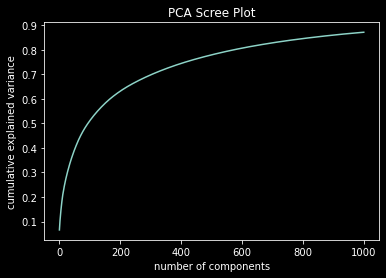

In [30]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA Scree Plot')
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
# display(pca_df.head(10))

### 3.b - Transform train/test Document-Term-matrix with PCA

In [36]:
dtm_train_pca = pca.transform(dtm_train)
dtm_test_pca = pca.transform(dtm_test)

Build DataFrame of PCA Components

In [37]:
col_names = ['PC_' + str(i) for i in range(1, pca.get_params()['n_components']+1)]
dtm_train_pca_df = pd.DataFrame(dtm_train_pca, columns=col_names, index=dtm_train.index)
dtm_test_pca_df = pd.DataFrame(dtm_test_pca, columns=col_names, index=dtm_test.index)

Combine PCA components and sentiment analysis scores into one DataFrame

In [38]:
X_train_post_dtm_pca = pd.concat([X_train[['body_polarity','body_subjectivity']], dtm_train_pca_df], axis=1)
X_test_post_dtm_pca = pd.concat([X_test[['body_polarity','body_subjectivity']],dtm_test_pca_df], axis=1)

In [39]:
X_train_post_dtm_pca.head()

,body_polarity,body_subjectivity,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_991,PC_992,PC_993,PC_994,PC_995,PC_996,PC_997,PC_998,PC_999,PC_1000
10404,0.089698,0.382755,6.721061,3.945245,-3.471639,-2.540806,-1.755792,-1.530580,-4.131935,3.995938,...,0.247410,0.112819,-0.221178,0.358408,0.121966,0.925809,-0.304316,0.440954,0.425969,0.257728
46696,-0.140000,0.601585,5.761562,0.596871,-2.237162,-3.185774,-1.131865,-2.262611,-2.888901,0.091407,...,-0.314662,0.072516,-0.014814,-0.019344,-0.070520,-0.195476,-0.211167,0.320596,-0.209645,0.665674
94429,0.034758,0.575265,1.966241,-1.712639,-0.909869,0.264536,0.921555,5.895030,1.228308,-1.104063,...,-0.137693,0.266202,0.027230,0.108337,0.118239,-0.208619,0.185121,0.059169,0.201602,0.008044
32916,-0.009470,0.545676,-0.266428,0.267073,2.156327,-2.304956,-2.705226,-2.705801,-0.498127,0.245638,...,0.249692,-0.153850,0.602140,0.090367,0.155175,-0.365895,0.125291,-0.052552,0.576324,0.068642
90078,0.196644,0.494792,2.398379,-0.615294,-0.211558,-3.215111,-1.241750,1.164917,4.107578,2.698774,...,0.196581,-0.242619,-0.278308,-0.118178,0.125242,0.219422,0.074999,-0.049525,0.260460,0.220446


In [40]:
print(X_train_post_dtm_pca.shape, y_train.shape)
print(X_test_post_dtm_pca.shape, y_test.shape)

(96480, 1002) (96480,)
(975, 1002) (975,)


#### 3.c Oversample minority class with SMOTE

In [41]:
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train_post_dtm_pca, y_train)
Counter(y_train_smote)

Counter({0: 70299, 1: 70299})

# Models

## 1 - Random Forest Models

### 1.a Vanilla Random Forest, no tuning hyperparameters 

In [24]:
start = time.time()
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train_smote, y_train_smote)
end = time.time()
print((end-start)/60)

2.407271953423818


In [26]:
y_pred_train = rfc.predict(X_train_smote)
print(confusion_matrix(y_train_smote,y_pred_train))
# print(classification_report(y_train,y_pred_train))
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train)}')

[[70299     0]
 [    0 70299]]
F1 Score = 1.0
Accuracy Score = 1.0


In [27]:
y_pred_test = rfc.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test))
# print(classification_report(y_test,y_pred_test))
print(f'F1 Score = {f1_score(y_test,y_pred_test)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test)}')

[[614  96]
 [229  36]]
F1 Score = 0.181360201511335
Accuracy Score = 0.6666666666666666


### 1.b weighted random forest

In [28]:
start = time.time()
rfc2 = RandomForestClassifier(n_jobs=-1, max_depth=50, n_estimators=500)
rfc2.fit(X_train_smote, y_train_smote)
end = time.time()
print((end-start)/60)

10.862314200401306


In [29]:
y_pred_train_2 = rfc2.predict(X_train_smote)
print(confusion_matrix(y_train_smote,y_pred_train_2))
# print(classification_report(y_train,y_pred_train_2))
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train_2)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train_2)}')

[[70182   117]
 [    0 70299]]
F1 Score = 0.9991685321394307
Accuracy Score = 0.9991678402253232


In [30]:
y_pred_test_2 = rfc2.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test_2))
# print(classification_report(y_test,y_pred_test_2))
print(f'F1 Score = {f1_score(y_test,y_pred_test_2)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_2)}')

[[615  95]
 [229  36]]
F1 Score = 0.18181818181818182
Accuracy Score = 0.6676923076923077


## 2 - Logistic Regression

In [42]:
start = time.time()

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_smote, y_train_smote)

end = time.time()
print((end-start)/60)

0.17628188133239747


In [45]:
pickle.dump(lr, open('models/lr.sav', 'wb'))

In [43]:
y_pred_train_lr = lr.predict(X_train_smote)
print(confusion_matrix(y_train_smote,y_pred_train_lr))
# print(classification_report(y_train,y_pred_train_lr))
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train_lr)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train_lr)}')

[[41760 28539]
 [20638 49661]]
F1 Score = 0.668839520804854
Accuracy Score = 0.6502297329976244


In [44]:
y_pred_test_lr = lr.predict(X_test_post_dtm_pca)
print(confusion_matrix(y_test,y_pred_test_lr))
# print(classification_report(y_test,y_pred_test_lr))
print(f'F1 Score = {f1_score(y_test,y_pred_test_lr)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_lr)}')

[[409 301]
 [122 143]]
F1 Score = 0.40338504936530317
Accuracy Score = 0.5661538461538461


#### 2.b Logistic Regression with dtm 

In [74]:
start = time.time()

lr_dtm = LogisticRegression(max_iter=500)
lr_dtm.fit(X_train_dtm_smote, y_train_smote)

end = time.time()
print((end-start)/60)

2.077534731229146


In [76]:
y_pred_train_lr = lr_dtm.predict(X_train_dtm_smote)
print(confusion_matrix(y_train_smote,y_pred_train_lr))
# print(classification_report(y_train,y_pred_train_lr))
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train_lr)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train_lr)}')

[[55851 14448]
 [16430 53869]]
F1 Score = 0.7772407225717088
Accuracy Score = 0.7803809442524076


In [77]:
y_pred_test_lr = lr_dtm.predict(dtm_test)
print(confusion_matrix(y_test,y_pred_test_lr))
# print(classification_report(y_test,y_pred_test_lr))
print(f'F1 Score = {f1_score(y_test,y_pred_test_lr)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_lr)}')

[[531 179]
 [168  97]]
F1 Score = 0.3585951940850277
Accuracy Score = 0.6441025641025641


## 3. Naive Bayes

In [67]:
y_train

10404    0
46696    1
94429    0
32916    0
90078    0
        ..
55624    0
60224    0
50582    1
33799    0
7920     1
Name: is_asshole, Length: 96480, dtype: int64

In [66]:
oversample = SMOTE()
X_train_dtm_smote, y_train_smote = oversample.fit_resample(dtm_train, y_train)
Counter(y_train_smote)

Counter({0: 70299, 1: 70299})

In [68]:
nb = MultinomialNB()
nb.fit(X_train_dtm_smote, y_train_smote)

MultinomialNB()

In [69]:
y_pred_train_nb = nb.predict(X_train_dtm_smote)
print(confusion_matrix(y_train_smote,y_pred_train_nb))
# print(classification_report(y_train,y_pred_train_nb))
print(f'F1 Score = {f1_score(y_train_smote,y_pred_train_nb)}')
print(f'Accuracy Score = {accuracy_score(y_train_smote,y_pred_train_nb)}')

[[51295 19004]
 [18088 52211]]
F1 Score = 0.7378916573625224
Accuracy Score = 0.7361840139973541


In [70]:
y_pred_test_nb = nb.predict(dtm_test)
print(confusion_matrix(y_test,y_pred_test_nb))
# print(classification_report(y_test,y_pred_test_nb))
print(f'F1 Score = {f1_score(y_test,y_pred_test_nb)}')
print(f'Accuracy Score = {accuracy_score(y_test,y_pred_test_nb)}')

[[511 199]
 [158 107]]
F1 Score = 0.37478108581436076
Accuracy Score = 0.6338461538461538


## Trying Predictions

In [2]:
procto = Proctologist()

In [25]:
texts = ['I pushed my mom off a cliff, and my whole family is mad at me, but I don\'t feel bad about it, aita?',
        'My boyfriend cheated on me, so I kicked him out of the house I own, he threatened to call the police, and I told him to leave me alone.', 
        'I cheated on my boyfriend and he kicked me out of his house, I broke in in the middle of night, I did not pay rent.',
        'I talked to my ex on a regular basis, and my girlfriend isn\'t happy about it, she said she\'s going to leave me', 
        'my biological parents spent years looking for me, but I am happy with my adoptive parents and consider them my real family, I don\'t want to have any contact with my biological parents after they abandoned me']

In [26]:
procto.judgement(texts)

array([1, 0, 1, 1, 1])